<a href="https://colab.research.google.com/github/olcaykursun/ML/blob/main/neuralnets/autoencoder_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Autoencoders are particularly good for feature extraction, dimensionality reduction, and denoising data.
# Below we demonstrate reconstructing a noisy version of a digit image using an autoencoder.
# Encoder part is, among many alternatives, taken straight out of first few blocks of a pretrained net.

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the MobileNetV2 using only a subset of the network to reduce training time
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3), alpha=0.5)

# Select only part of the model to use as an encoder
encoder = models.Model(inputs=base.input, outputs=base.get_layer('block_3_expand_relu').output, name='my_base_model')

encoder.trainable = False

# Build the model (feature extractor + decoder)
autoencoder_model = models.Sequential()
autoencoder_model.add(layers.InputLayer(input_shape=(32, 32, 3)))
autoencoder_model.add(encoder)

# Decoder part to reconstruct the images
autoencoder_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(layers.UpSampling2D((2, 2)))
autoencoder_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(layers.UpSampling2D((2, 2)))
autoencoder_model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_model.summary()

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = tf.image.resize(tf.expand_dims(x_train, axis=-1), [32, 32])
x_test = tf.image.resize(tf.expand_dims(x_test, axis=-1), [32, 32])

x_train = tf.image.grayscale_to_rgb(x_train)
x_test = tf.image.grayscale_to_rgb(x_test)

x_train_original = x_train/255  # Save original x_train for autoencoder
x_train = preprocess_input(x_train)
x_test_original = x_test/255  # Save original x_test for autoencoder
x_test = preprocess_input(x_test)

print(x_test.numpy().max())
print(x_test_original.numpy().max())

# Add noise to the MNIST data (resized to 32x32 for consistency)
noise_factor = 0.5
if noise_factor < 0: #colored noise
    x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
    x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
else:
    grayscale_noise = tf.random.normal(shape=(x_train.shape[0], 32, 32, 1))
    x_train_noisy = x_train + noise_factor * tf.image.grayscale_to_rgb(grayscale_noise)
    grayscale_noise = tf.random.normal(shape=(x_test.shape[0], 32, 32, 1))
    x_test_noisy = x_test + noise_factor * tf.image.grayscale_to_rgb(grayscale_noise)



# For extra showcasing, draw a random horizontal line across the noisy image
# neural network will learn to erase it
def add_horizontal_line(image, line_thickness=1):
    y = np.random.randint(0, image.shape[0])
    image[y:y+line_thickness, :, :] = 1  # Set line to white
    return image

x_train_noisy = tf.map_fn(lambda img: add_horizontal_line(img.numpy()), x_train_noisy, dtype=tf.float32)
x_test_noisy = tf.map_fn(lambda img: add_horizontal_line(img.numpy()), x_test_noisy, dtype=tf.float32)



#Do not let the noisy pixels get outside -1..+1 range as the pretrained model expects that range
x_train_noisy = tf.clip_by_value(x_train_noisy, -1., 1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, -1., 1.)

# Train the model
autoencoder_model.fit(x_train_noisy, x_train_original, epochs=1, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test_original))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_base_model (Functional)  (None, 8, 8, 96)          9584      
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          55360     
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 up_sampling2d_5 (UpSamplin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 3)        

In [ ]:
# Use the model to reconstruct the test images
reconstructed_imgs = autoencoder_model.predict(x_test_noisy)

# Evaluate the model
test_loss = autoencoder_model.evaluate(x_test_noisy, x_test_original)
print(f'Test loss: {test_loss:.4f}')

313/313 [==============================] - 3s 9ms/step - loss: 0.1188
Test loss: 0.1188


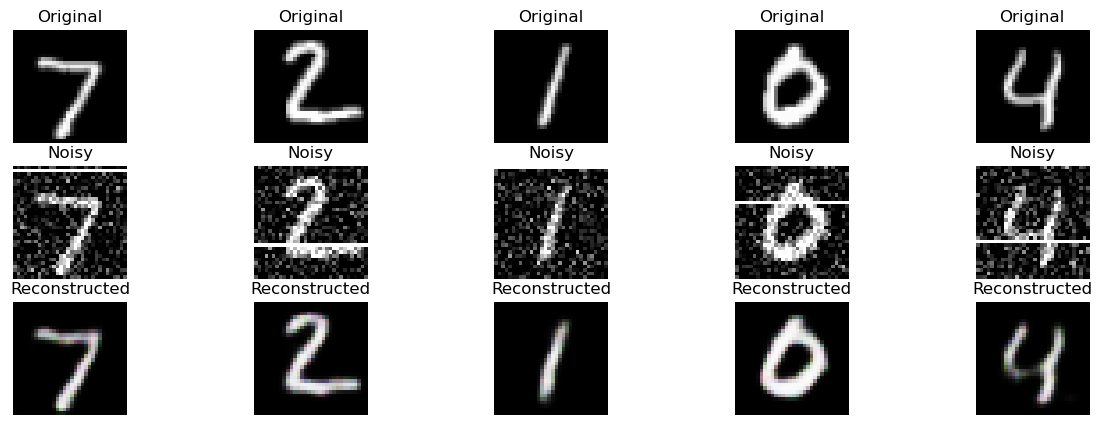

In [ ]:
# Plot a few original, noisy, and reconstructed images
import matplotlib.pyplot as plt

num_images = 5
plt.figure(figsize=(15, 5))

for i in range(num_images):
    # Display original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(tf.cast(x_test_original[i] * 255, tf.uint8).numpy())
    plt.title("Original")
    plt.axis('off')

    # Display noisy image
    ax = plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(tf.cast((x_test_noisy[i]+1)/2 * 255, tf.uint8).numpy())
    plt.title("Noisy")
    plt.axis('off')

    # Display reconstructed image
    ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(tf.cast(reconstructed_imgs[i] * 255, tf.uint8).numpy())
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()